In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from datetime import datetime
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
tesla_stocks = pd.read_csv('/home/jovyan/courses-txg/RNN/part2/data/tesla_stocks.csv')

In [111]:
tesla_stocks.Date = pd.to_datetime(tesla_stocks.Date)

In [4]:
#資料共有六個資訊，日期、開盤、當日最高、當日最低、收盤、成交量
tesla_stocks.head()

,Date,Open,High,Low,Close,Volume
0,4-Aug-14,234.38,240.50,233.27,238.52,5967406
1,5-Aug-14,237.47,242.99,235.69,238.49,5388581
2,6-Aug-14,238.90,251.42,238.58,248.93,9249265
3,7-Aug-14,250.12,256.69,249.12,252.39,7478926
4,8-Aug-14,251.16,251.76,246.50,248.13,5099061


In [8]:
data_to_use = tesla_stocks.iloc[:,1:6].values

# Scaler

In [9]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_use)
scaled_label = scaled_data[:, 3]

In [12]:
print("std: ", scaled_label.std())
print("mean: ", scaled_label.mean())

std:  0.9999999999999999
mean:  4.69935671799008e-16


# Plot all feature

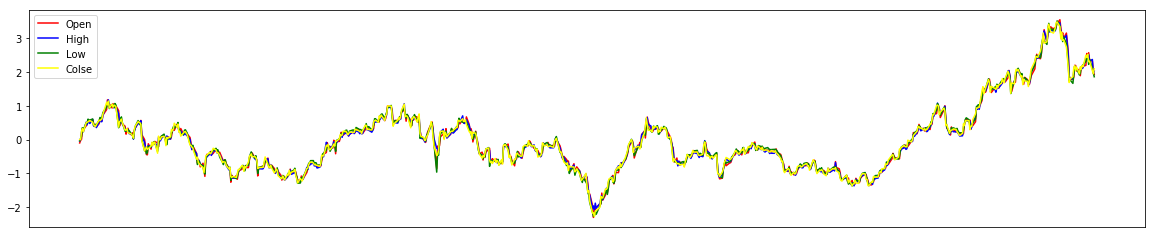

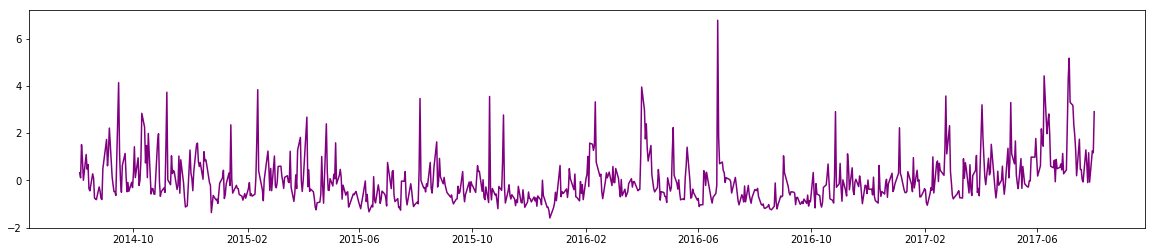

In [52]:
'Take feature Open, High, Low, Close, Volume'
plt.figure(figsize=(20, 4))
plt.plot(tesla_stocks.Date, scaled_data[:, 0], color='red', label='Open')
plt.plot(tesla_stocks.Date, scaled_data[:, 1], color='blue', label='High')
plt.plot(tesla_stocks.Date, scaled_data[:, 2], color='green', label='Low')
plt.plot(tesla_stocks.Date, scaled_data[:, 3], color='yellow', label='Colse')
plt.xticks([])
plt.legend()
plt.show()
plt.figure(figsize=(20, 4))
plt.plot(tesla_stocks.Date, scaled_data[:, 4], color='purple', label='Volume')
plt.show()

# Conifg

In [40]:
window_size = 7
n_features = 5
n_classes = 1
hidden_layer_size = 512
number_of_layer = 1
dropout = True
dropout_rate = 0.8
learning_rate = 0.001
batch_size = 8
epochs = 200

# Data preprocessing

In [64]:
def window_data(data, label, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i: i + window_size])
        y.append([label[i + window_size]])
        i += 1
    
    assert len(X) == len(y)

    return X, y

In [65]:
X, y = window_data(scaled_data, scaled_label, window_size)

In [66]:
X_train = np.array(X[: 700])
X_test = np.array(X[700: ])
y_train = np.array(y[: 700])
y_test = np.array(y[700: ])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (700, 7, 5)
y_train size: (700, 1)
X_test size: (49, 7, 5)
y_test size: (49, 1)


### Create the RNN

In [27]:
import tensorflow as tf

In [87]:
def LSTM_layer(hidden_layer_size, batch_size, number_of_layer, dropout=True, dropout_rate=0.8):
    layer = tf.contrib.rnn.BasicLSTMCell(hidden_layer_size)
    
    if dropout:
        layer = tf.contrib.rnn.DropoutWrapper(layer, output_keep_prob=dropout_rate)
    
    cell = tf.contrib.rnn.MultiRNNCell([layer] * number_of_layer)
    init_state = cell.zero_state(batch_size, tf.float32)
    
    return cell, init_state

def output_layer(lstm_output, n_classes):
    last_layer = lstm_output[:, -1, :]
    output = tf.layers.dense(inputs=last_layer, units=n_classes)
    
    return output

def opt_and_loss(logits, targets, learning_rate):
    loss = tf.reduce_mean(tf.pow(logits-targets, 2)) / batch_size
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    gradients = optimizer.compute_gradients(loss)
    
    capped_values = [(tf.clip_by_value(grad, -5, 5), var) for grad, var in gradients if grad is not None]
    
    train_optimizer = optimizer.apply_gradients(capped_values)
    
    return loss, train_optimizer

In [92]:
main_graph = tf.Graph()
sess = tf.Session(graph=main_graph)

with main_graph.as_default():
    with tf.name_scope('inputs'):
        inputs = tf.placeholder(tf.float32, shape=[None, window_size, n_features], name='inputs')
        targets = tf.placeholder(tf.float32, shape=[None, n_classes], name='targets')
        keep_prob = tf.placeholder(tf.float32, shape=[], name='keep_prob')

    with tf.variable_scope('LSTM_layer'):
        cell, init_state = LSTM_layer(hidden_layer_size, tf.shape(inputs)[0], number_of_layer, dropout, dropout_rate)
        outputs, states = tf.nn.dynamic_rnn(cell, inputs=inputs, initial_state=init_state)

    with tf.variable_scope('output_layer'):
        logits = output_layer(outputs, n_classes)

    with tf.name_scope('opt_and_loss'):
        loss, opti = opt_and_loss(logits, targets, learning_rate)

        init = tf.global_variables_initializer()

In [93]:
sess.run(init)

In [94]:
for i in range(200):
    k = 0
    epoch_loss = []
    while (k + batch_size) <= len(X_train):
        X_batch = X_train[k: k+batch_size]
        y_batch = y_train[k: k+batch_size]
        
        batch_loss, _ = sess.run([loss, opti], feed_dict={inputs: X_batch, targets: y_batch, keep_prob: 0.8})
        epoch_loss.append(batch_loss)
        
        k += batch_size
    if i % 30 == 0:
        print('Epochs {}/{}'.format(i, epochs), ', Current loss: {}'.format(np.mean(epoch_loss)))

Epochs 0/200 , Current loss: 0.010218936949968338
Epochs 30/200 , Current loss: 0.002834960585460067
Epochs 60/200 , Current loss: 0.0025545957032591105
Epochs 90/200 , Current loss: 0.0025006935466080904
Epochs 120/200 , Current loss: 0.0018742363899946213
Epochs 150/200 , Current loss: 0.001742309657856822
Epochs 180/200 , Current loss: 0.0012940589804202318


In [96]:
train_set_pred = np.array([])
for i in range(len(X_train)):
    o = sess.run(logits, feed_dict={inputs: X_train[i: i+1], keep_prob: 1.0})
    train_set_pred = np.append(train_set_pred, o)
print("Done")

Done


In [97]:
test_set_pred = np.array([])
for i in range(len(X_test)):
    o = sess.run(logits, feed_dict={inputs: X_test[i: i+1], keep_prob: 1.0})
    test_set_pred = np.append(test_set_pred, o)
print("Done")

Done


In [113]:
train = [None] * window_size
for i in range(len(X_train)):
    train.append(train_set_pred[i])
    
test = [None] * (window_size + len(X_train))
test_loss = 0

for i in range(len(X_test)):
    test.append(test_set_pred[i])
    test_loss += (test_set_pred[i]- y_test[i]) ** 2
    train.append(None)
print(test_loss / len(X_test))

[0.16207871]


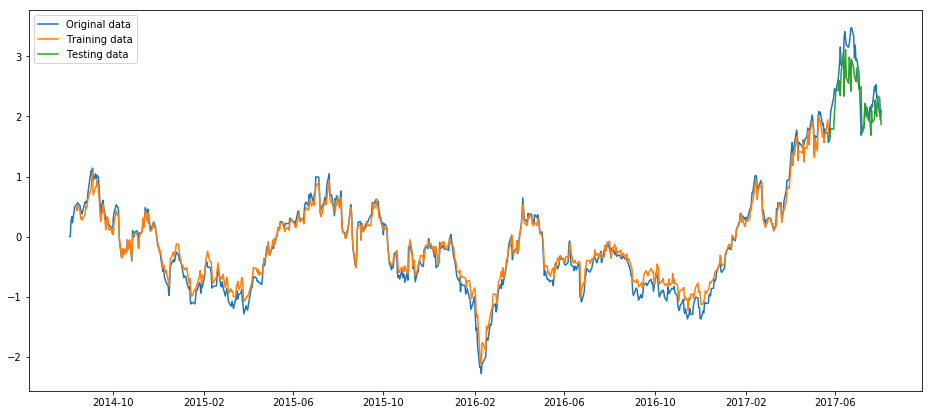

In [112]:
plt.figure(figsize=(16, 7))
plt.plot(tesla_stocks.Date, scaled_label, label='Original data')
plt.plot(tesla_stocks.Date, train, label='Training data')
plt.plot(tesla_stocks.Date, test, label='Testing data')
plt.legend()
plt.show()